### ARIMA model forecast

In this task you should construct ARIMA model for a time series containing data about dynamics of mounthly wages in Russian Federation since 1993 year. You will train the best model (according to AIC criterion) on hystorical data and use it to make  forecast for the next 4 years.

Run the cells and fill necessary gaps.

Documentation on Statsmodels: https://www.statsmodels.org/stable/index.html

In [1]:
# let's import necassary packages...
%pylab inline
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error

warnings.simplefilter('ignore')

Populating the interactive namespace from numpy and matplotlib


<Figure size 864x432 with 0 Axes>

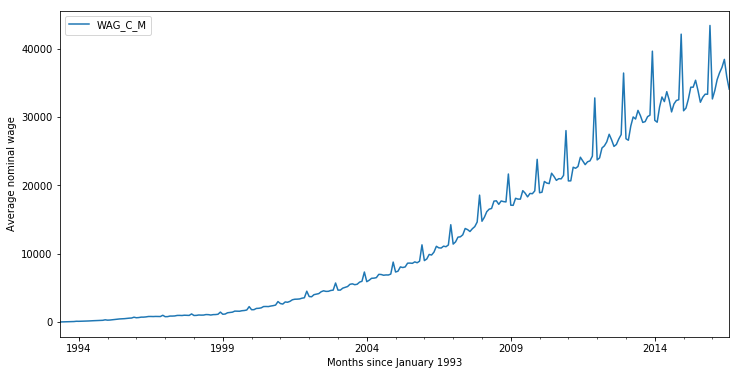

In [2]:
# let's load data...
WAG = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True,encoding='cp1251')
plt.figure(figsize(12,6))
WAG.plot()
plt.ylabel('Average nominal wage')
plt.xlabel('Months since January 1993')
plt.show()

In [3]:
WAG.head(10)
print (WAG.shape)

(280, 1)


In [4]:
WAG.head()

,WAG_C_M
month,
1993-05-01,37.5
1993-06-01,47.4
1993-07-01,56.0
1993-08-01,65.4
1993-09-01,80.9


Dickey-Fuller test: p=0.991667


<Figure size 1080x720 with 0 Axes>

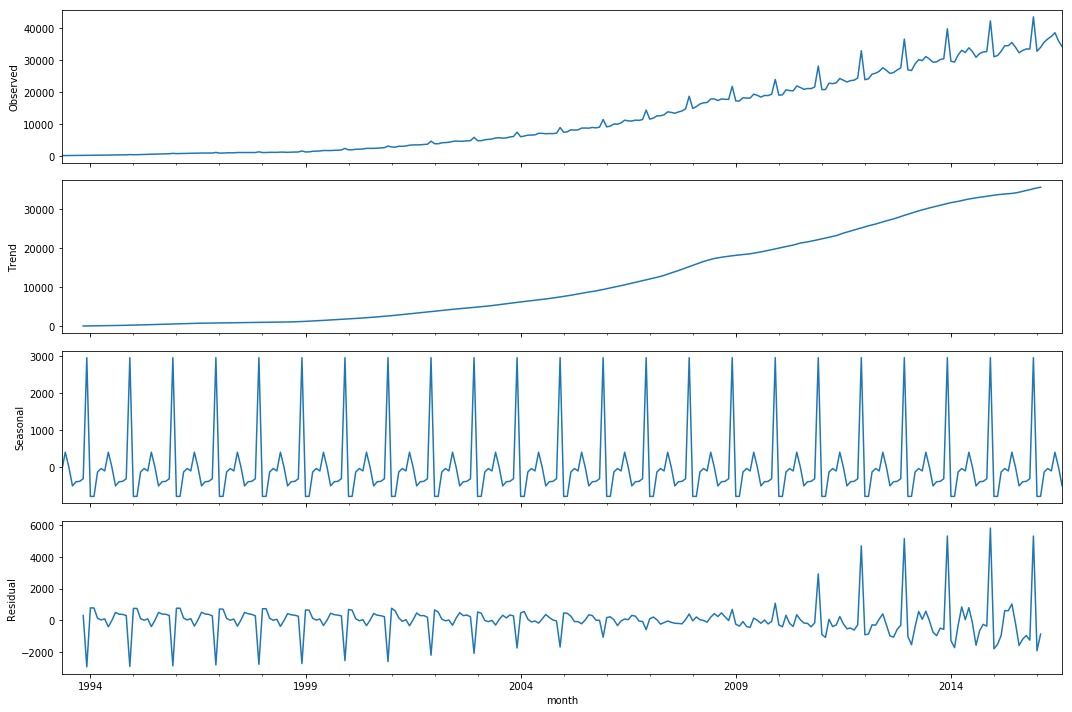

In [5]:
# evaluate components of time-series
# evaluate Dickey-Fuller test for time-series stationarity

plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(WAG.WAG_C_M).plot()
fuller_test = sm.tsa.stattools.adfuller(WAG.WAG_C_M)
print("Dickey-Fuller test: p=%f" % fuller_test[1])
adf = fuller_test[0]
critical_values = fuller_test[4]
plt.show()

Best Box-Cox parameter: 0.257063
Dickey-Fuller test: p=0.688484


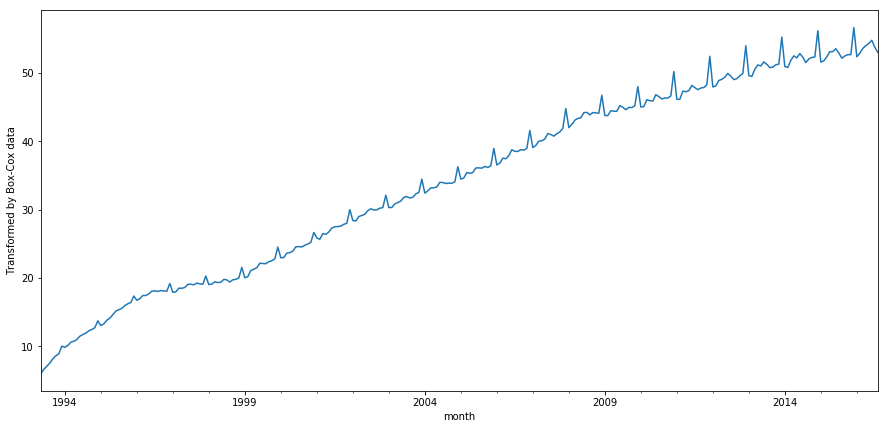

In [6]:
# Box-Cox transformation for dispersion stationarity
WAG['WAG_C_M_box'], lmbda = stats.boxcox(WAG.WAG_C_M)
plt.figure(figsize(15,7))
WAG.WAG_C_M_box.plot()
plt.ylabel('Transformed by Box-Cox data')
print("Best Box-Cox parameter: %f" % lmbda)
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(WAG.WAG_C_M_box)[1])

Dickey-Fuller test: p=0.033416


<Figure size 1080x720 with 0 Axes>

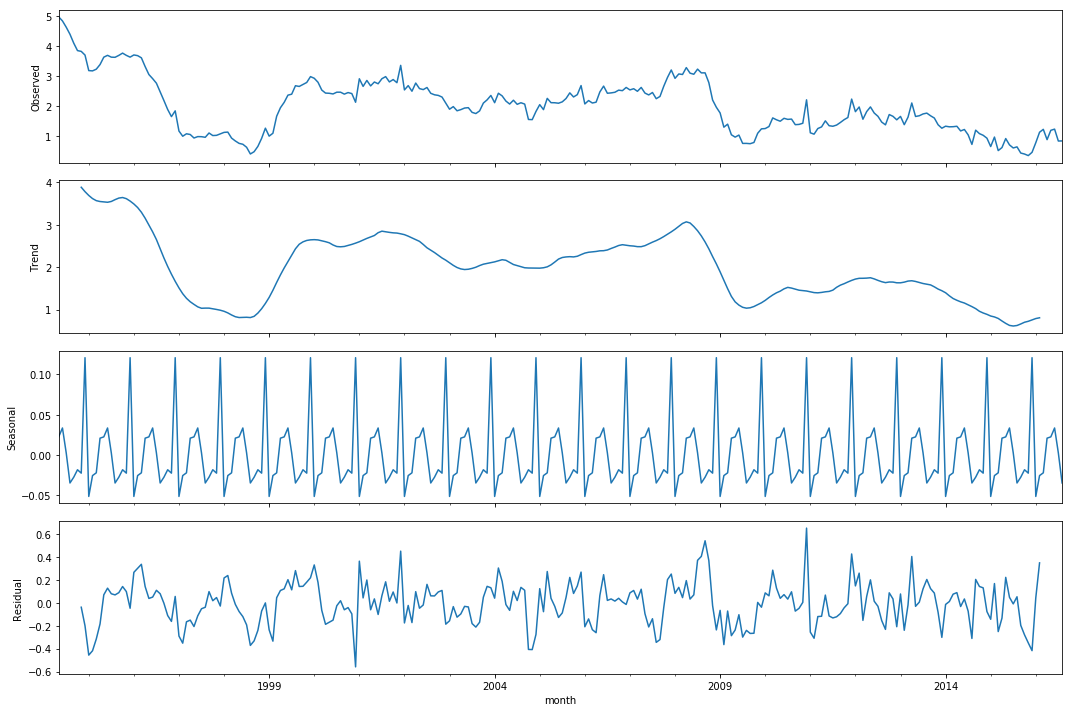

In [7]:
# seasonal difference for 12 months
WAG['WAG_C_M_box_diff'] = WAG.WAG_C_M_box - WAG.WAG_C_M_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(WAG.WAG_C_M_box_diff[12:]).plot()
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(WAG.WAG_C_M_box_diff[12:])[1])
plt.show()

Dickey-Fuller test: p=0.000001


<Figure size 1080x720 with 0 Axes>

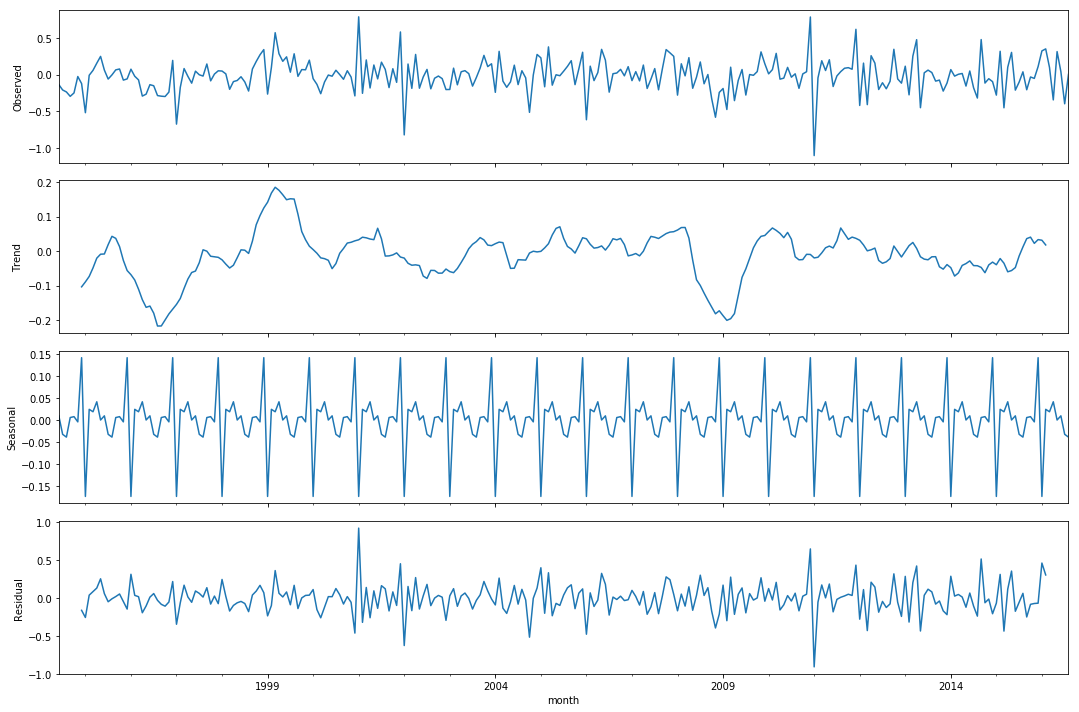

In [8]:
# CODE 1
# Make additional 1-step difference by analogy with previous cell and evaluate Dickey-Fuller p-value
# Did the data become more stationary?
WAG['WAG_C_M_box_diff2'] = WAG.WAG_C_M_box_diff - WAG.WAG_C_M_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(WAG.WAG_C_M_box_diff2[13:]).plot()
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(WAG.WAG_C_M_box_diff2[13:])[1])
plt.show()

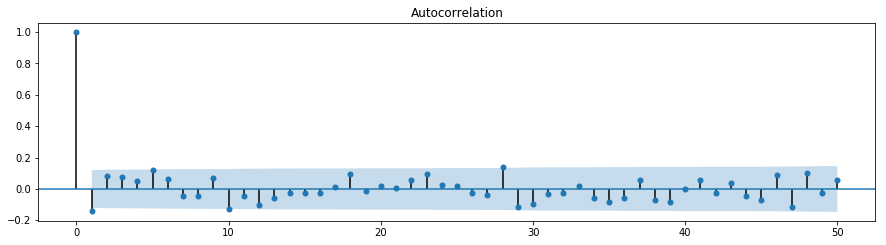

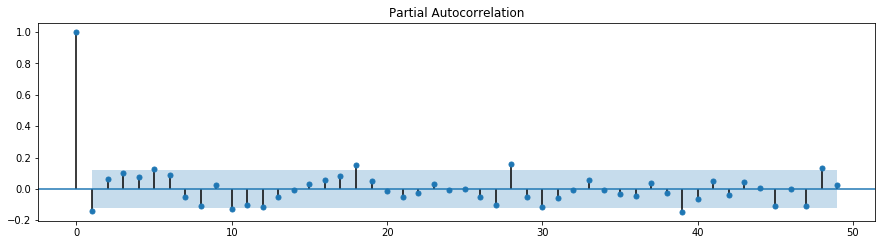

In [9]:
# let's calculate autocorrelation and partial autocorrelation components

plt.figure(figsize(15,8))

# autocorrelation 
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(WAG.WAG_C_M_box_diff2[13:].values.squeeze(), lags=50, ax=ax)
pylab.show()

# partial autocorrelation 
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(WAG.WAG_C_M_box_diff2[13:].values.squeeze(), lags=49, ax=ax)
pylab.show()

In [10]:
# CODE 2
# Choose parameters for SARIMA model based on Autocorrelation and Partial Autocorrelation graphs

ps = range(0, 2)
d  = 1
qs = range(0, 2)
Ps = range(0, 2)
D  = 1
Qs = range(0,2)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print ("Number of analysed models:", len(parameters_list))

Number of analysed models: 16


In [11]:
# here we will choose the best model

# %%time
results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    
    #try except for the case of wrong parameters
    try:
        model=sm.tsa.statespace.SARIMAX(WAG.WAG_C_M_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
        
    #print wrong parameters and go on
    # AIC criteria: 
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic

    # save best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
        results.append([param, model.aic])
    

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  2.68it/s]


In [12]:
# Top models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters        aic
7  (1, 0, 1, 0) -30.710017
6  (1, 0, 0, 1) -30.430058
5  (0, 1, 1, 0) -29.931231
4  (0, 1, 0, 1) -29.666433
3  (0, 1, 0, 0) -28.036602


In [13]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        WAG_C_M_box   No. Observations:                  280
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                  18.355
Date:                            Sat, 20 Jul 2019   AIC                            -30.710
Time:                                    17:30:59   BIC                            -19.948
Sample:                                05-01-1993   HQIC                           -26.387
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1516      0.047     -3.250      0.001      -0.243      -0.060
ar.S.L12      -0.1259      0.047   

Student test: p=0.144427
Dickey-Fuller test: p=0.0000058569051629269662553


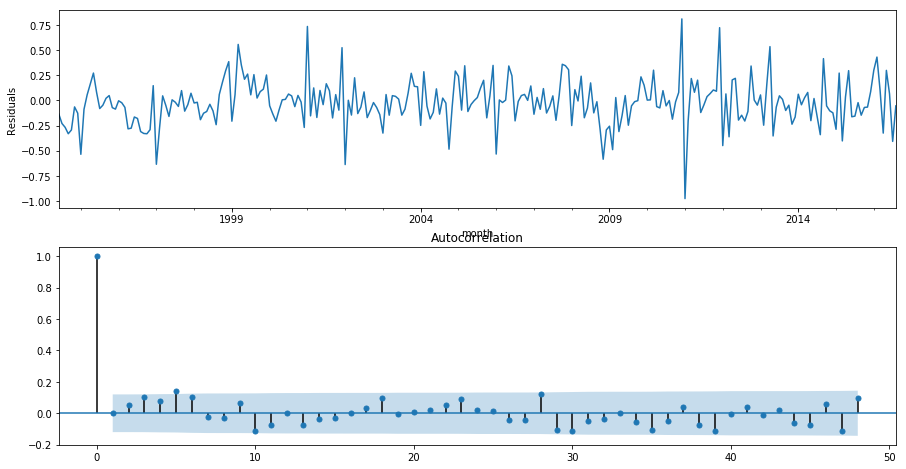

In [14]:
# evaluate Dickey-Fuller test for the best model

plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Student test: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Dickey-Fuller test: p=%.25f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

In [15]:
#inverse Box-Cox transformation:

def invboxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda*y + 1)/lmbda)
    
WAG['model'] = invboxcox(best_model.fittedvalues, lmbda)

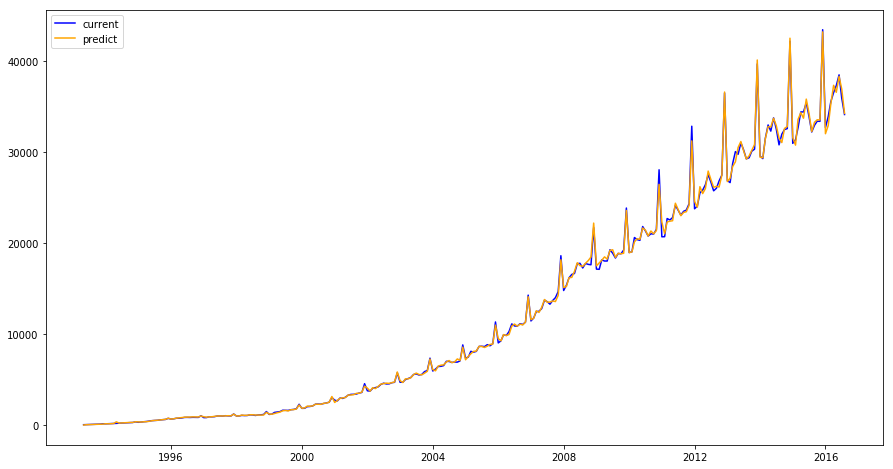

In [16]:
# CODE 3
# Plot the best model and original time series on the same figure

plt.plot(WAG['WAG_C_M'], color = 'blue')
plt.plot(WAG['model'], color = 'orange')

plt.legend(('current', 'predict'))
plt.show()

In [17]:
# CODE 4
# Evaluate the MAPE metric to check  best model's performance
#MAPE = ### %
MAPE = 100/len(WAG['WAG_C_M']) * sum(abs(WAG['WAG_C_M'] - WAG['model'])/(WAG['WAG_C_M']))
print(MAPE)

2.9804493275866966


In [18]:
WAG.tail()

,WAG_C_M,WAG_C_M_box,WAG_C_M_box_diff,WAG_C_M_box_diff2,model
month,,,,,
2016-04-01,36497.0,54.019167,0.884016,-0.343701,37300.195761
2016-05-01,37270.0,54.332006,1.195576,0.311560,36530.445160
2016-06-01,38447.0,54.799216,1.234663,0.039087,38280.375209
2016-07-01,35888.0,53.769214,0.838092,-0.396571,36884.965668
2016-08-01,34095.0,53.014532,0.841125,0.003033,34221.936921


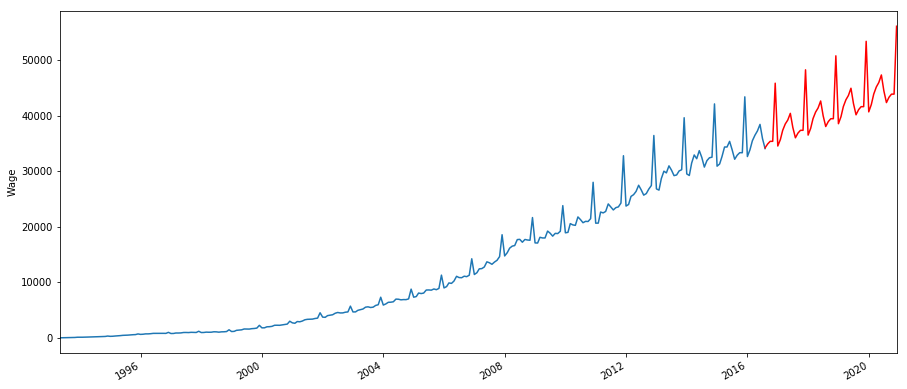

In [19]:
# CODE 5
# Make the forecast until 2021 year. Fill the None's: 

WAG2 = WAG[['WAG_C_M']]
#
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,53)]
#
future = pd.DataFrame(index=date_list, columns= WAG2.columns)
# future = pd.DataFrame(index=pd.date_range(start="2016-08-01", end='2020-12-01', periods=53), columns= WAG2.columns)
#
WAG2 = pd.concat([WAG2, future])
#
WAG2['forecast'] = invboxcox(best_model.predict(start="2016-08-01", end='2020-12-01'), lmbda)

plt.figure(figsize(15,7))
WAG2.WAG_C_M.plot()
WAG2.forecast.plot(color='r')
plt.ylabel('Wage')
plt.show()